In [103]:
#importing libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import LSTM
import seaborn as sns

In [104]:
#import data to dataframe
df=pd.read_csv('googlestock.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602
...,...,...,...,...,...,...
2022-03-18,2668.489990,2724.879883,2645.169922,2722.510010,2722.510010,2223100
2022-03-21,2723.270020,2741.000000,2681.850098,2722.030029,2722.030029,1341600
2022-03-22,2722.030029,2821.000000,2722.030029,2797.360107,2797.360107,1774800


In [105]:
#checking data types and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4431 entries, 2004-08-19 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4431 non-null   float64
 1   High       4431 non-null   float64
 2   Low        4431 non-null   float64
 3   Close      4431 non-null   float64
 4   Adj Close  4431 non-null   float64
 5   Volume     4431 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 242.3 KB


there are 4431 rows so we're seeing that there aren't any null values. Also the date range for the data is shown here from August 19th 2004 to March 24th 2022. 

In [106]:
#checking duplicates. 
df.duplicated().sum()

0

Even though numbers can easily be duplicated. Since the numbers in the graph go down to the sixth decimal, then it is unlikely that any numbers that are duplicated are real. 

In [107]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4.431000e+03
mean,693.087345,699.735595,686.078751,693.097367,693.097367,6.444992e+06
std,645.118799,651.331215,638.579488,645.187806,645.187806,7.690351e+06
min,49.644646,50.920921,48.028027,50.055054,50.055054,4.656000e+05
25%,248.558563,250.853355,245.813309,248.415916,248.415916,1.695600e+06
50%,434.924927,437.887878,432.687683,435.330322,435.330322,3.778418e+06
75%,1007.364990,1020.649994,997.274994,1007.790008,1007.790008,8.002390e+06
max,3025.000000,3030.929932,2977.979980,2996.770020,2996.770020,8.215117e+07


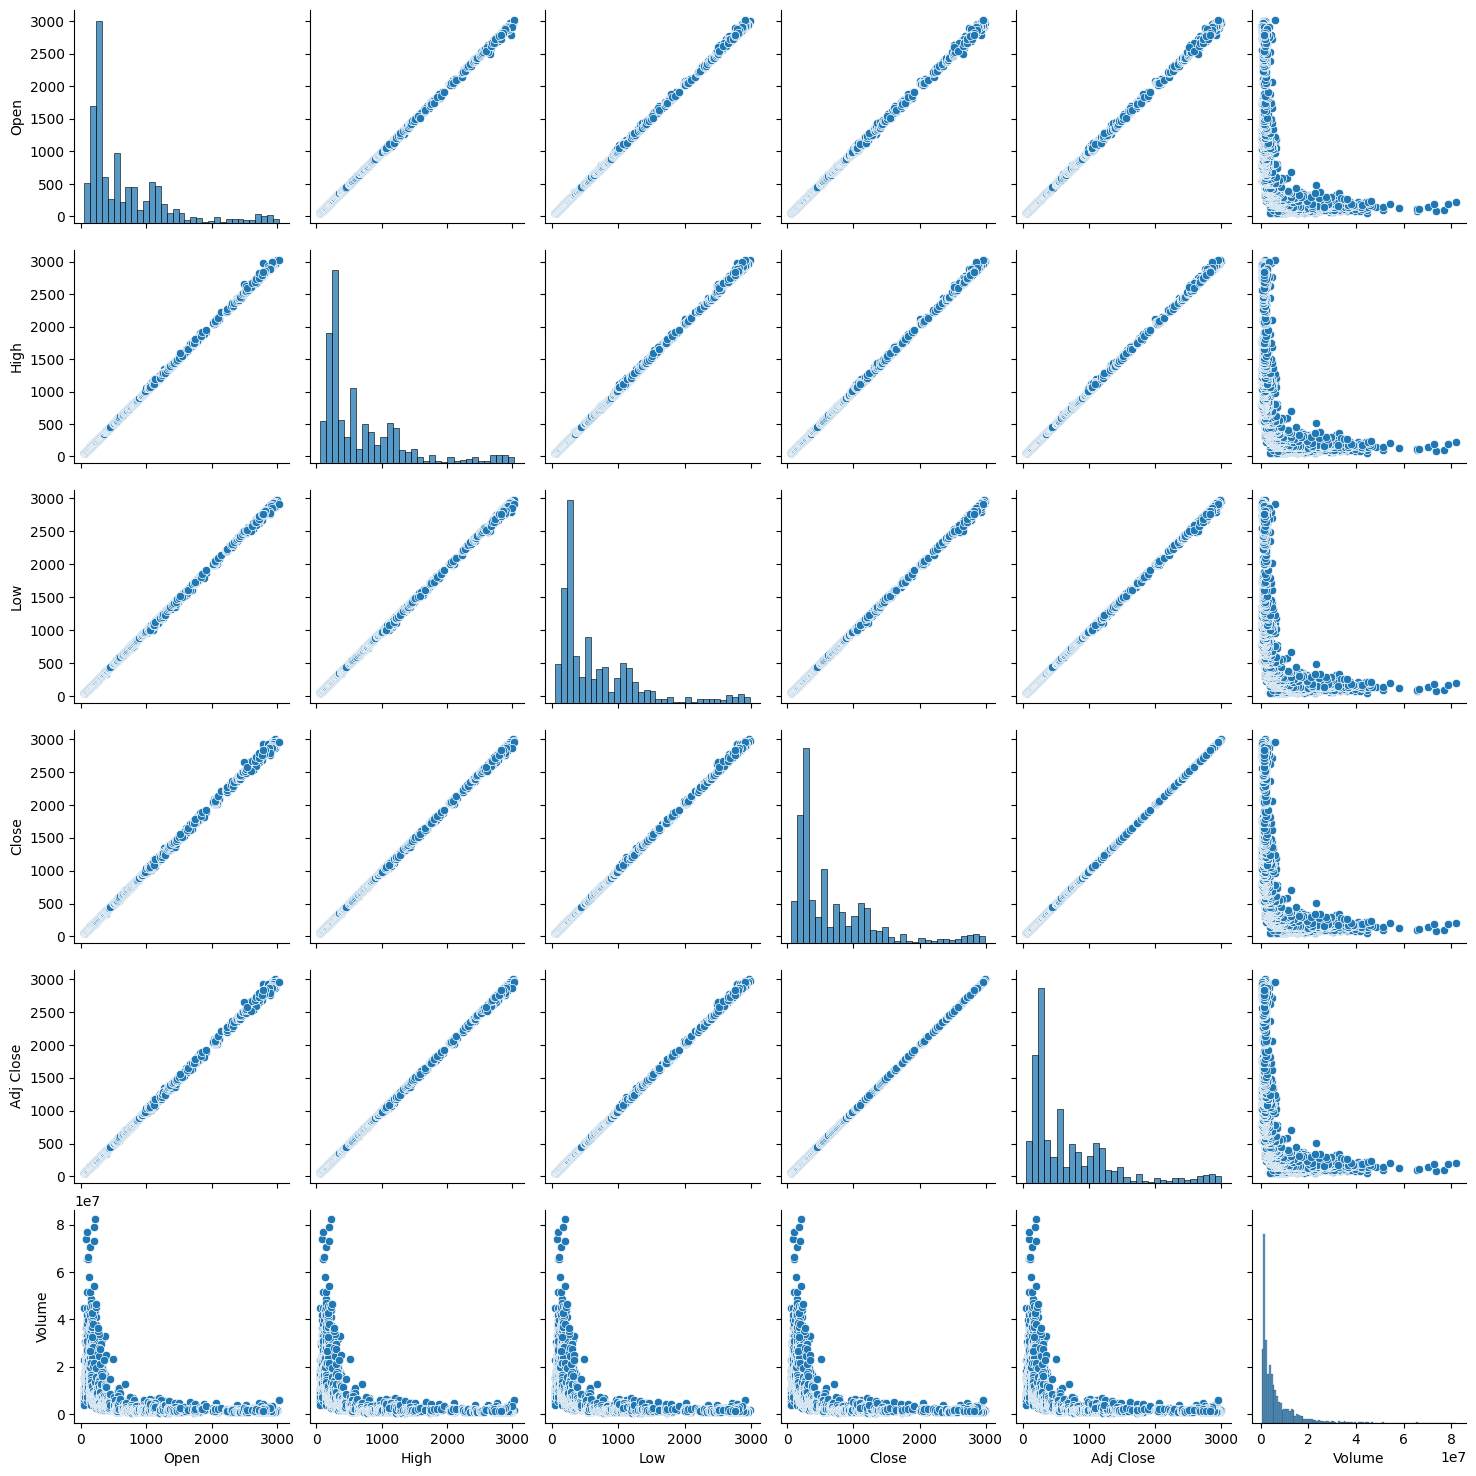

In [108]:
#pairplot of all numeric variables
sns.pairplot(df)
plt.show()

The above graph all looks very similar to each other. This might be because the numbers are all so close together that it's hard to see the minor changes in data. 

<AxesSubplot: >

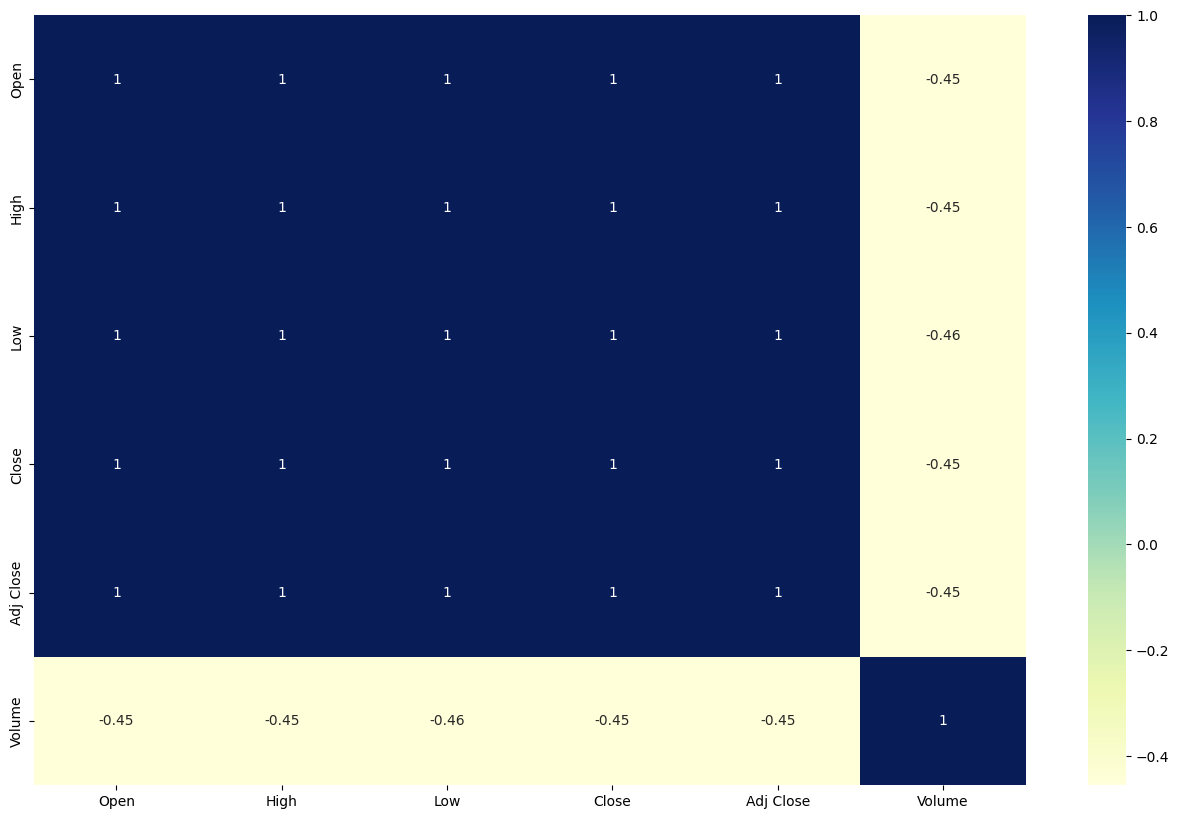

In [109]:
plt.figure(figsize = (16, 10))
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")

In [110]:
df['close_minus_open'] = df.apply(lambda row: row.Close - row.Open, axis=1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,close_minus_open
Date,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,0.170170
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,3.653652
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,-0.675678
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,-3.188186
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,0.520523


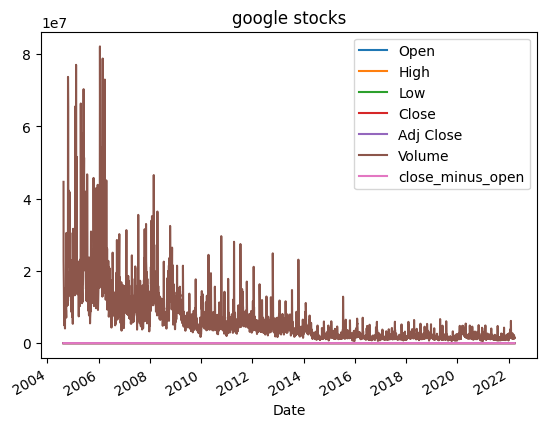

In [111]:
df.plot()
plt.title("google stocks")
plt.show()

This graph is indicating that google stocks are being traded less at a volume that it used to be. However, this doesn't account for stock slices or split stocks. Also, what this could mean is that the majority of shares were sold in the beginning (i.e. investors in the company)  and will hold onto those shares for decades without selling them. This means that they're not being sold and will remain in the same person's possesion during this entire period. 

In [112]:
#copying dataframe
df2 = df.copy()

In [113]:
#making the dates into a proper column so that I can graph it. 
df2.reset_index(inplace=True)
df2

,Date,Open,High,Low,Close,Adj Close,Volume,close_minus_open
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,0.170170
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,3.653652
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,-0.675678
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,-3.188186
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,0.520523
...,...,...,...,...,...,...,...,...
4426,2022-03-18,2668.489990,2724.879883,2645.169922,2722.510010,2722.510010,2223100,54.020020
4427,2022-03-21,2723.270020,2741.000000,2681.850098,2722.030029,2722.030029,1341600,-1.239991
4428,2022-03-22,2722.030029,2821.000000,2722.030029,2797.360107,2797.360107,1774800,75.330078
4429,2022-03-23,2774.050049,2791.770020,2756.699951,2765.510010,2765.510010,1257700,-8.540039


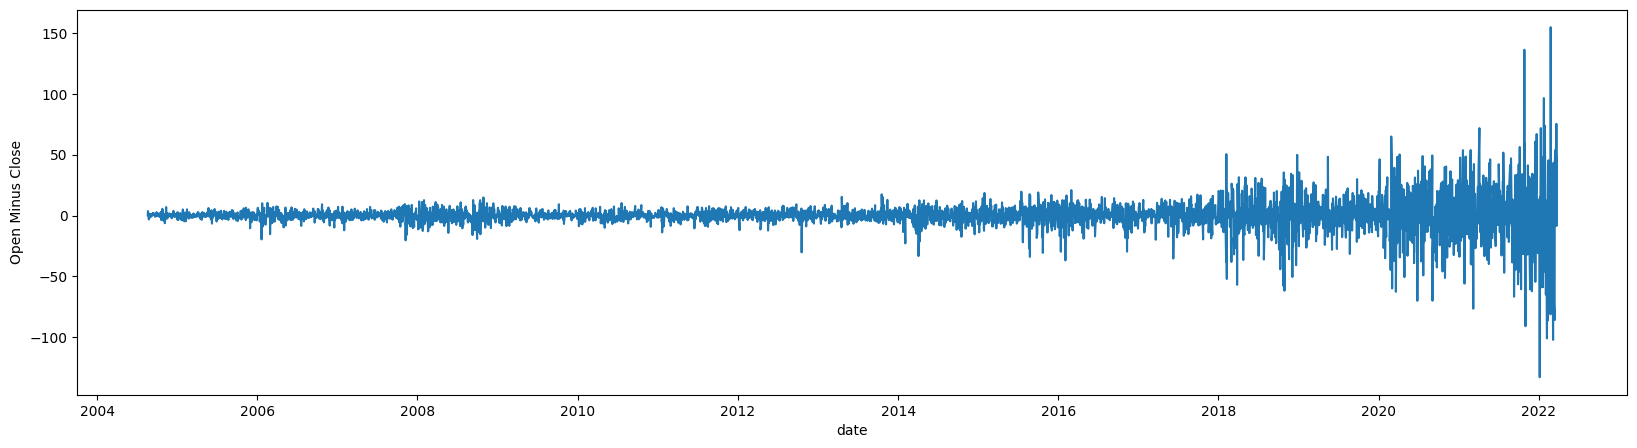

In [114]:
#line graph
plt.figure(figsize=(20,5))
plt.plot(df2['Date'], df2['close_minus_open'])
plt.ylabel('Open Minus Close')
plt.xlabel('date')
plt.show()

This is a very interesting graph showing how the changes between the open and close dates increase through time. This makes sense as stocks become more and more expensive, and the dollar decreases in value, that there is a greater increase in the stock prices by day. 

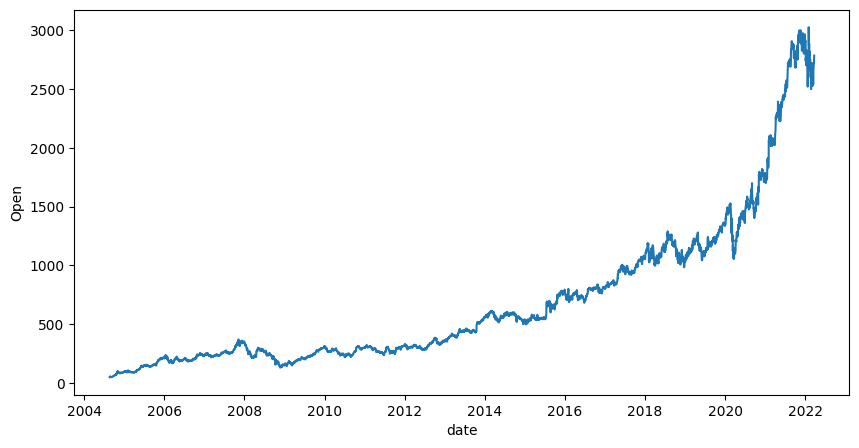

In [128]:
#line graph
plt.figure(figsize=(10,5))
plt.plot(df2['Date'], df2['Open'])
plt.ylabel('Open')
plt.xlabel('date')
plt.show()

#was going to try to remove negative values but can't seem to do that here. 
df["close_minus_open"] = pd.to_numeric(df["close_minus_open"])
df.close_minus_open.abs()
df.head()

#copying dataframe
df3 = df[["Open", "High", "Low", "Close"]].copy()
df3.head()

In [129]:
#train/test
df_train = df.iloc[4000:-100]
df_test = df.iloc[-100:]

In [130]:
dftrain_values = df_train.iloc[:,1:2].values #Open

In [131]:
#scale values to 0 to 1
min_max = MinMaxScaler(feature_range = (0,1))
train_fit = min_max.fit_transform(dftrain_values)
print(train_fit[0:5])
print(len(train_fit))

[[0.06732854]
 [0.09014273]
 [0.05525049]
 [0.06406471]
 [0.05076191]]
331


In [132]:
#x_train is data during the last 60 days.
#y_data is the data before 60 days
x_train = []
y_train = []

In [133]:
for i in range(60,len(train_fit)):
    x_train.append(train_fit[i-60:i, 0])
    y_train.append(train_fit[i,0])
x_train,y_train = np.array(x_train),np.array(y_train)
print(x_train.shape,y_train.shape)

(271, 60) (271,)
